<!-- <img src="https://github.com/CorndelDataAnalyticsDiploma/workshop/blob/master/Corndel%20Digital%20Logo%20Centre.png?raw=true" alt="Corndel" width ="301.5" align="left"> -->


<img src="https://github.com/DrPBaksh/image_processing/blob/main/logos/logo_2.png?raw=true" alt="Corndel" width ="301.5" align="left">


# NLP: Natural Language Processing

- In this notebook I want to compare the accuracy using a higging face pre trained model with some fine tunning to the traditional bag of words process

- First lets streamline the process of making the traditional classifier


In [1]:
# General purpose
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import load_files
from sklearn.datasets import fetch_openml

# Text feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer # combines the previous two functions into one step

# Classifiers
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC # Support Vector Machine

# modelling with a pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # tune hyperparameters with Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold

# Evaluation
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
train_data = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/document_classification.csv?raw=true')

In [3]:
count_vect = CountVectorizer(strip_accents='ascii', 
                             analyzer='word',
                             stop_words=stopwords.words('english'),
                             max_df=1.0,              # Change from default 1.0 to increasingly small percentages below 1.0 such as 0.5, 0.3
                             min_df=1                 # CHange from default 1 to increasingly higher numbers
                             )   

pipeline = Pipeline([
    ('vect', count_vect),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [4]:
train_data

,Unnamed: 0,text,target,target_name
0,0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1,comp.graphics
1,1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1,comp.graphics
2,2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3,soc.religion.christian
3,3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3,soc.religion.christian
4,4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
...,...,...,...,...
2252,2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,2255,From: Dan Wallach <dwallach@cs.berkeley.edu>\n...,2,sci.med


In [5]:
pipeline.fit(train_data.text, train_data.target_name)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='ascii')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [6]:
train_predictions = pipeline.predict(train_data.text)
trad_train_acc = (train_predictions == train_data.target_name).sum() / len(train_predictions)

In [7]:
test_data = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/document_classification_test_data.csv?raw=true')

In [8]:
test_predictions = pipeline.predict(test_data.text)
trad_test_pred = (test_predictions == test_data.target_name).sum() / len(test_predictions)


                        precision    recall  f1-score   support

           alt.atheism       0.97      0.72      0.83       319
         comp.graphics       0.95      0.94      0.95       389
               sci.med       0.95      0.87      0.91       396
soc.religion.christian       0.75      0.98      0.85       398

              accuracy                           0.89      1502
             macro avg       0.91      0.88      0.88      1502
          weighted avg       0.90      0.89      0.89      1502



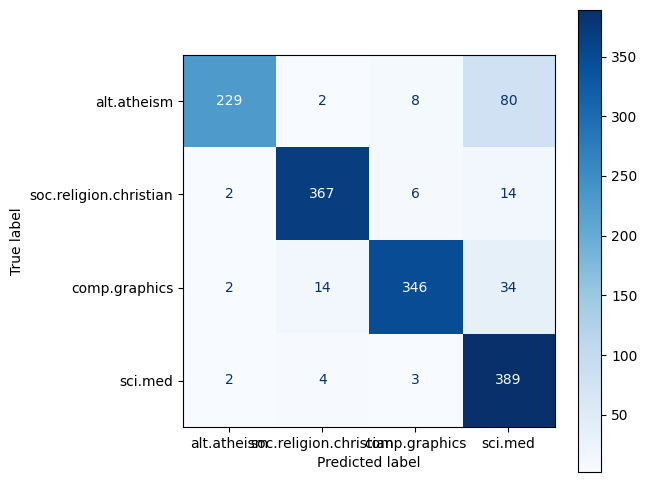

In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (6,6)

print(metrics.classification_report(y_true=test_data.target_name, y_pred=test_predictions,
    target_names=np.unique(test_data.target_name))) # it is the training data since the unique values there map to the correct names

cm=metrics.confusion_matrix(y_true=test_data.target_name,y_pred=test_predictions)

cmd=ConfusionMatrixDisplay(cm, display_labels=['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med'])
cmd.plot(cmap=plt.cm.Blues,values_format='g');

## Hugging Face implimentation via Fine Tunning 

In [10]:
!pip install datasets
!pip install datasets evaluate transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 20.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.6 MB/s eta 0:0

In [11]:
import pandas as pd
from datasets import Dataset

# Assuming you have train_data and test_data DataFrames already

# Function to create a Dataset object from a DataFrame with 'text' and 'target' columns
def create_dataset(df):
    rows = []

    for idx, (text, label) in df[['text', 'target']].iterrows():
        row = {'text': text, 'label': label, 'idx': idx}
        rows.append(row)

    return Dataset.from_dict(pd.DataFrame(rows))

# Create Dataset objects for both train and test sets
train_dataset = create_dataset(train_data)
test_dataset = create_dataset(test_data)

# Create a dictionary containing the Dataset objects
datasets = {
    "train": train_dataset,
    "test": test_dataset,
}


from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments

# Assuming you have the my_dict dictionary with the train and test Dataset objects
# under the 'dataset' keys

# Create a new dictionary containing the Dataset objects
raw_datasets = {
    "train": datasets["train"],
    "test": datasets["test"],
}

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

# Map the tokenize_function to each Dataset object in raw_datasets separately
tokenized_datasets = {
    split: dataset.map(tokenize_function, batched=True)
    for split, dataset in raw_datasets.items()
}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments("test-trainer")

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=train_data.target.nunique())

from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.train()

Map:   0%|          | 0/2257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1502 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.247300


TrainOutput(global_step=849, training_loss=0.15841976745389796, metrics={'train_runtime': 633.0781, 'train_samples_per_second': 10.695, 'train_steps_per_second': 1.341, 'total_flos': 1764552575843304.0, 'train_loss': 0.15841976745389796, 'epoch': 3.0})

In [12]:
predictions = trainer.predict(tokenized_datasets["train"])
preds = np.argmax(predictions.predictions, axis=-1)
print(predictions.predictions.shape, predictions.label_ids.shape)
test_pred_dnn = (preds == train_data.target).sum() / len(train_data)

(2257, 4) (2257,)


In [13]:
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
print(predictions.predictions.shape, predictions.label_ids.shape)
train_pred_dnn = (preds == test_data.target).sum() / len(test_data)

(1502, 4) (1502,)


                        precision    recall  f1-score   support

           alt.atheism       0.93      0.90      0.91       319
         comp.graphics       0.97      0.95      0.96       389
               sci.med       0.96      0.96      0.96       396
soc.religion.christian       0.95      0.98      0.96       398

              accuracy                           0.95      1502
             macro avg       0.95      0.95      0.95      1502
          weighted avg       0.95      0.95      0.95      1502



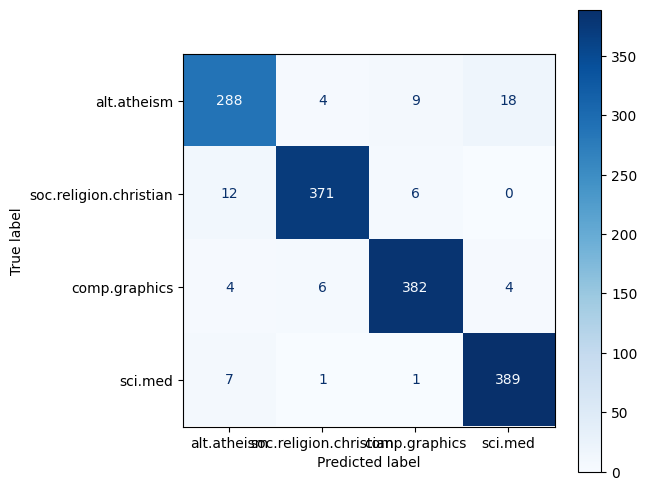

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (6,6)

print(metrics.classification_report(y_true=test_data.target.values, y_pred=preds,
    target_names=np.unique(test_data.target_name))) # it is the training data since the unique values there map to the correct names

cm=metrics.confusion_matrix(y_true=test_data.target,y_pred=preds)

cmd=ConfusionMatrixDisplay(cm, display_labels=['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med'])
cmd.plot(cmap=plt.cm.Blues,values_format='g');

In [15]:
print('DNN accuracy :', train_pred_dnn, 'Trad Accuracy: ', trad_test_pred) 

DNN accuracy : 0.952063914780293 Trad Accuracy:  0.8861517976031957


### Extra: Shall we see the comparision between the two methods when we work with very small amounts of data

In [16]:
train_data_fraction = train_data.sample(300)

In [17]:
count_vect = CountVectorizer(strip_accents='ascii', 
                             analyzer='word',
                             stop_words=stopwords.words('english'),
                             max_df=1.0,              # Change from default 1.0 to increasingly small percentages below 1.0 such as 0.5, 0.3
                             min_df=1                 # CHange from default 1 to increasingly higher numbers
                             )   

pipeline = Pipeline([
    ('vect', count_vect),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [18]:
pipeline.fit(train_data_fraction.text, train_data_fraction.target_name)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='ascii')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [19]:
train_predictions = pipeline.predict(train_data.text)
trad_train_acc = (train_predictions == train_data.target_name).sum() / len(train_predictions)
trad_train_acc

0.8094816127603013

In [20]:
test_predictions = pipeline.predict(test_data.text)
trad_test_pred = (test_predictions == test_data.target_name).sum() / len(test_predictions)
trad_test_pred

0.715046604527297

                        precision    recall  f1-score   support

           alt.atheism       0.99      0.25      0.40       319
         comp.graphics       0.98      0.77      0.86       389
               sci.med       0.88      0.76      0.82       396
soc.religion.christian       0.51      0.99      0.67       398

              accuracy                           0.72      1502
             macro avg       0.84      0.69      0.69      1502
          weighted avg       0.83      0.72      0.70      1502



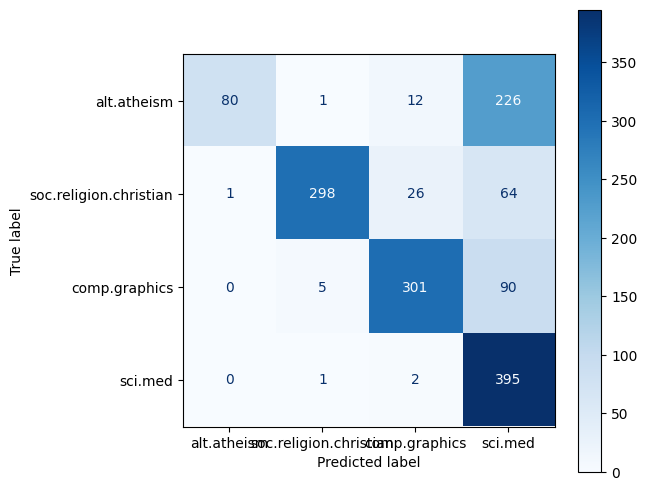

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (6,6)

print(metrics.classification_report(y_true=test_data.target_name, y_pred=test_predictions,
    target_names=np.unique(test_data.target_name))) # it is the training data since the unique values there map to the correct names

cm=metrics.confusion_matrix(y_true=test_data.target_name,y_pred=test_predictions)

cmd=ConfusionMatrixDisplay(cm, display_labels=['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med'])
cmd.plot(cmap=plt.cm.Blues,values_format='g');

**Now lets see what the DNN transfer learning will do**

In [22]:
!pip install datasets
!pip install datasets evaluate transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
train_data_fraction = train_data.sample(300)
train_data_fraction.target.value_counts()

3    90
2    82
1    73
0    55
Name: target, dtype: int64

In [24]:
import pandas as pd
from datasets import Dataset

# Assuming you have train_data and test_data DataFrames already

# Function to create a Dataset object from a DataFrame with 'text' and 'target' columns
def create_dataset(df):
    rows = []

    for idx, (text, label) in df[['text', 'target']].iterrows():
        row = {'text': text, 'label': label, 'idx': idx}
        rows.append(row)

    return Dataset.from_dict(pd.DataFrame(rows))

# Create Dataset objects for both train and test sets
train_dataset = create_dataset(train_data_fraction)
test_dataset = create_dataset(test_data)

# Create a dictionary containing the Dataset objects
datasets = {
    "train": train_dataset,
    "test": test_dataset,
}


from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments

# Assuming you have the my_dict dictionary with the train and test Dataset objects
# under the 'dataset' keys

# Create a new dictionary containing the Dataset objects
raw_datasets = {
    "train": datasets["train"],
    "test": datasets["test"],
}

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

# Map the tokenize_function to each Dataset object in raw_datasets separately
tokenized_datasets = {
    split: dataset.map(tokenize_function, batched=True)
    for split, dataset in raw_datasets.items()
}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments("test-trainer")

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=train_data.target.nunique())

from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.train()

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1502 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss


TrainOutput(global_step=114, training_loss=0.6061478999623081, metrics={'train_runtime': 85.1542, 'train_samples_per_second': 10.569, 'train_steps_per_second': 1.339, 'total_flos': 234053819947584.0, 'train_loss': 0.6061478999623081, 'epoch': 3.0})

In [25]:
predictions = trainer.predict(tokenized_datasets["train"])
preds = np.argmax(predictions.predictions, axis=-1)
print(predictions.predictions.shape, predictions.label_ids.shape)
train_pred_dnn = (preds == train_data_fraction.target).sum() / len(train_data_fraction)
train_pred_dnn

(300, 4) (300,)


0.9633333333333334

In [29]:
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
print(predictions.predictions.shape, predictions.label_ids.shape)
test_pred_dnn = (preds == test_data.target).sum() / len(test_data)
test_pred_dnn

(1502, 4) (1502,)


0.8901464713715047

                        precision    recall  f1-score   support

           alt.atheism       0.76      0.78      0.77       319
         comp.graphics       0.95      0.98      0.96       389
               sci.med       0.97      0.93      0.95       396
soc.religion.christian       0.87      0.85      0.86       398

              accuracy                           0.89      1502
             macro avg       0.88      0.89      0.88      1502
          weighted avg       0.89      0.89      0.89      1502



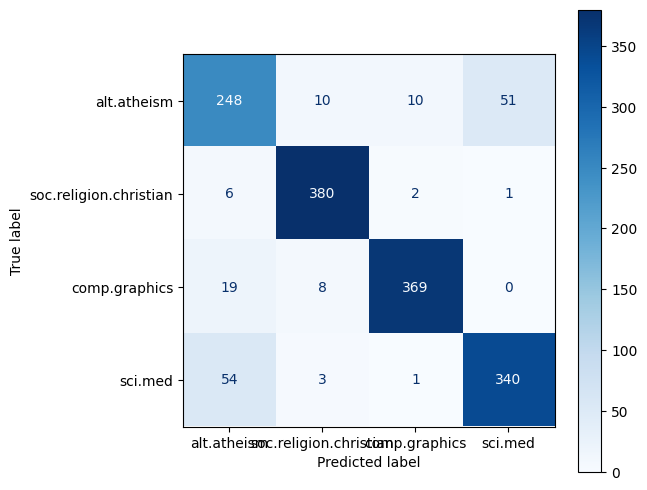

In [34]:


print(metrics.classification_report(y_true=test_data.target.values, y_pred=preds,
    target_names=np.unique(test_data.target_name))) # it is the training data since the unique values there map to the correct names

cm=metrics.confusion_matrix(y_true=test_data.target,y_pred=preds)

cmd=ConfusionMatrixDisplay(cm, display_labels=['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med'])
cmd.plot(cmap=plt.cm.Blues,values_format='g');

There is a signficant difference when we reduce the number of samples in the training set between using a transfer learning approach versus not. We can see that an accuracy of 89% was still achieved versus 72% with the traditional method